## **Brain Tumor Classification**

Transfer Learning EfficientNetB3 model

## **1. Setup**

### **1.1 Imports**

In [1]:
# Import necessary libraries
import pathlib
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, BatchNormalization, Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### **1.2 Constants**

In [2]:
BATCH_SIZE = 16
IMG_SIZE = 300
CLASS_MODE_SPARSE = 'sparse'
INTERPOLATION_BILINEAR = 'bilinear'
SEED = 1234

## **2. Load dataset**

### **2.1 Clone data on Google Colab**

In [3]:
# Download dataset
!git clone https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet

fatal: destination path 'Brain-Tumor-Classification-DataSet' already exists and is not an empty directory.


In [4]:
!ls /content/Brain-Tumor-Classification-DataSet/

Testing  Training


In [5]:
# Train set and test set data directory
train_data_dir = pathlib.Path('/content/Brain-Tumor-Classification-DataSet/Training')
test_data_dir = pathlib.Path('/content/Brain-Tumor-Classification-DataSet/Testing')

### **2.2 Load data and perform image augmentation**

#### **2.2.1. Create image data generators**

In [6]:
# Data generator without image augmentation
datagen_normal = ImageDataGenerator()

# Data generator with image augmentation
datagen_aug = ImageDataGenerator(rotation_range=10,
                                 height_shift_range=0.2,
                                 horizontal_flip=True,
                                 fill_mode='constant',
                                 validation_split=0.2
)

#### **2.2.2 Load data**

In [7]:
# Training set
train_data = datagen_aug.flow_from_directory(train_data_dir, 
                                             target_size=(IMG_SIZE, IMG_SIZE),
                                             batch_size=BATCH_SIZE, 
                                             class_mode='sparse',
                                             subset='training')

Found 2297 images belonging to 4 classes.


In [8]:
# Validation set
val_data = datagen_aug.flow_from_directory(train_data_dir, 
                                           target_size=(IMG_SIZE, IMG_SIZE), 
                                           batch_size=BATCH_SIZE, 
                                           class_mode='sparse',
                                           subset='validation')

Found 573 images belonging to 4 classes.


In [9]:
# Testing set
test_data = datagen_normal.flow_from_directory(test_data_dir, 
                                               target_size=(IMG_SIZE, IMG_SIZE), 
                                               class_mode='sparse')

Found 394 images belonging to 4 classes.


In [10]:
num_classes = 4

In [11]:
train_data.class_indices

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

#### **2.2.3 Compute the class weight**

In [12]:
# Get the Training set labels
train_labels = np.array([])

for batch in range(len(train_data)):
    x, y = train_data[batch]
    train_labels = np.concatenate([train_labels, y])

In [13]:
# Compute class weight
class_weights_dict = dict(enumerate(class_weight.compute_class_weight(class_weight='balanced', 
                                                                      classes=np.asarray(range(4)), 
                                                                      y=train_labels)))
print(class_weights_dict)

{0: 0.8687594553706506, 1: 0.8727203647416414, 2: 1.817246835443038, 3: 0.8674471299093656}


## **3. Build our CNN model based on EfficientNetB3 model**

Use EfficientNet as a feature extractor in our transfer learning workflow.

In [14]:
base_model = EfficientNetB3(weights='imagenet',  # Use ImageNet pre-trained weights
                            include_top=False,   # Do not include classifer at the top
                            input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the pretrained weights
base_model.trainable = False

In [15]:
# Rebuild model top
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(num_classes, activation='softmax', name='predict')(x)
model = Model(inputs, outputs)

In [16]:
base_learning_rate = 0.0001
model.compile(optimizer=Adam(learning_rate=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, mode='auto', verbose=1)

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 10, 10, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1536)              6144      
_________________________________________________________________
dense (Dense)                (None, 1024)              1573888   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
predict (Dense)              (None, 4)                 4100  

In [18]:
num_train_epochs = 15
train_history = model.fit(train_data, 
                          epochs=num_train_epochs, 
                          validation_data=val_data, 
                          class_weight = class_weights_dict,
                          verbose=1,
                          callbacks=earlystop)

Epoch 1/15
144/144 [==============================] - 65s 394ms/step - loss: 0.8072 - accuracy: 0.6922 - val_loss: 0.7494 - val_accuracy: 0.7417
Epoch 2/15
144/144 [==============================] - 55s 381ms/step - loss: 0.4587 - accuracy: 0.8098 - val_loss: 0.5578 - val_accuracy: 0.8063
Epoch 3/15
144/144 [==============================] - 55s 381ms/step - loss: 0.3649 - accuracy: 0.8537 - val_loss: 0.5070 - val_accuracy: 0.8010
Epoch 4/15
144/144 [==============================] - 55s 384ms/step - loss: 0.3218 - accuracy: 0.8659 - val_loss: 0.4889 - val_accuracy: 0.8237
Epoch 5/15
144/144 [==============================] - 55s 383ms/step - loss: 0.2695 - accuracy: 0.8825 - val_loss: 0.4734 - val_accuracy: 0.8412
Epoch 6/15
144/144 [==============================] - 55s 384ms/step - loss: 0.2504 - accuracy: 0.8990 - val_loss: 0.4620 - val_accuracy: 0.8464
Epoch 7/15
144/144 [==============================] - 55s 382ms/step - loss: 0.2199 - accuracy: 0.9055 - val_loss: 0.5177 - val_ac

The train accuracy is 95.39% and the validation accuracy is 83.60%.

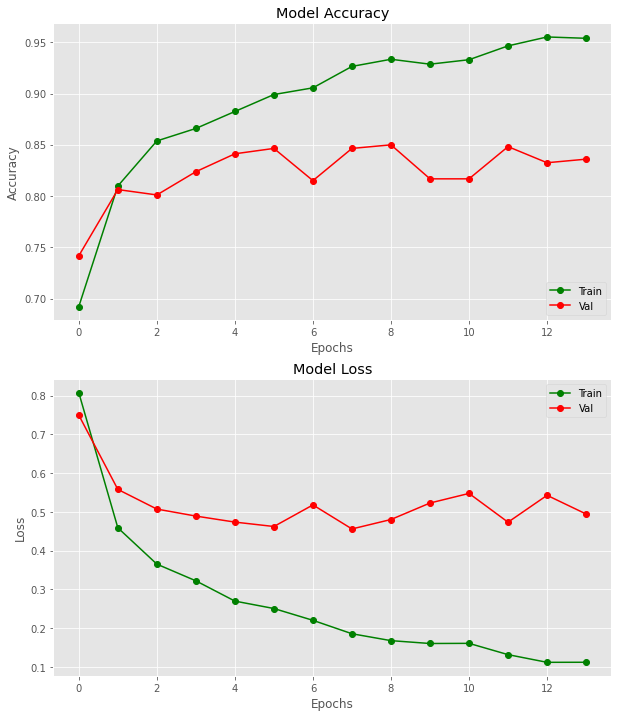

In [19]:
# Plot the training curves
train_acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

train_loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

plt.style.use('ggplot')
plt.figure(figsize=(10,12))

plt.subplot(2, 1, 1)
plt.plot(train_acc, 'go-', label='Training Accuracy')
plt.plot(val_acc, 'ro-', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(train_loss, 'go-', label='Training Loss')
plt.plot(val_loss, 'ro-', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

Evaluate model performance on the test dataset

In [20]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=2)
print(f'Test accuracy is {test_accuracy*100:.2f}%')

13/13 - 3s - loss: 1.6248 - accuracy: 0.7208
Test accuracy is 72.08%


## **4. Fine-tune the base EfficientNetB3 model**

In [21]:
# Structure of the EfficientNetB3 model
model.layers[1].summary()

Model: "efficientnetb3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 300, 300, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

To fine-tune the model, we choose to unfreeze the layers in block 7 while leaving the BatchNormalization layers frozen.

In [22]:
print("Number of layers in EfficientNetB3 model: ", len(base_model.layers))

Number of layers in EfficientNetB3 model:  384


In [23]:
# Function to return the index of a layer with the name of the layer
def getLayerIndexByName(model, layername):
    for idx, layer in enumerate(model.layers):
        if layer.name == layername:
            return idx


fine_tune_at_layer_idx = getLayerIndexByName(base_model, 'block7a_expand_conv')
print("Block 7 of EfficientNetB3 model starts at layer", fine_tune_at_layer_idx)

Block 7 of EfficientNetB3 model starts at layer 353


In [24]:
# Set all layers in block 7 to trainable while keeping the BatchNormalization layers frozen
base_model.trainable = True

# Keep the bottom layers frozen
for layer in base_model.layers[:fine_tune_at_layer_idx]:
    layer.trainable = False

# Keep the BatchNormalization layers at the top frozen
for layer in base_model.layers[fine_tune_at_layer_idx:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 10, 10, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1536)              6144      
_________________________________________________________________
dense (Dense)                (None, 1024)              1573888   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
predict (Dense)              (None, 4)                 4100  

In [26]:
model.compile(optimizer=Adam(learning_rate=base_learning_rate/10),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
num_tune_epochs = 50
total_epochs = num_train_epochs + num_tune_epochs
tuned_history = model.fit(train_data, 
                          epochs=total_epochs,
                          initial_epoch=train_history.epoch[-1] ,
                          validation_data=val_data, 
                          class_weight = class_weights_dict,
                          verbose=1,
                          callbacks=earlystop)

Epoch 14/65
144/144 [==============================] - 65s 397ms/step - loss: 0.1029 - accuracy: 0.9613 - val_loss: 0.4989 - val_accuracy: 0.8255
Epoch 15/65
144/144 [==============================] - 55s 386ms/step - loss: 0.0938 - accuracy: 0.9669 - val_loss: 0.4842 - val_accuracy: 0.8394
Epoch 16/65
144/144 [==============================] - 56s 387ms/step - loss: 0.0888 - accuracy: 0.9643 - val_loss: 0.4631 - val_accuracy: 0.8586
Epoch 17/65
144/144 [==============================] - 56s 386ms/step - loss: 0.0926 - accuracy: 0.9647 - val_loss: 0.4665 - val_accuracy: 0.8586
Epoch 18/65
144/144 [==============================] - 56s 388ms/step - loss: 0.0762 - accuracy: 0.9691 - val_loss: 0.4664 - val_accuracy: 0.8586
Epoch 19/65
144/144 [==============================] - 56s 386ms/step - loss: 0.0666 - accuracy: 0.9747 - val_loss: 0.4595 - val_accuracy: 0.8464
Epoch 20/65
144/144 [==============================] - 56s 388ms/step - loss: 0.0693 - accuracy: 0.9765 - val_loss: 0.4928 -

In [28]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=2)
print(f'Test accuracy is {test_accuracy*100:.2f}%')

13/13 - 2s - loss: 1.7034 - accuracy: 0.7386
Test accuracy is 73.86%


Unfreezing block 7 helps to improve the test accuracy from 53.05% to 67.01% which is about 14%. 

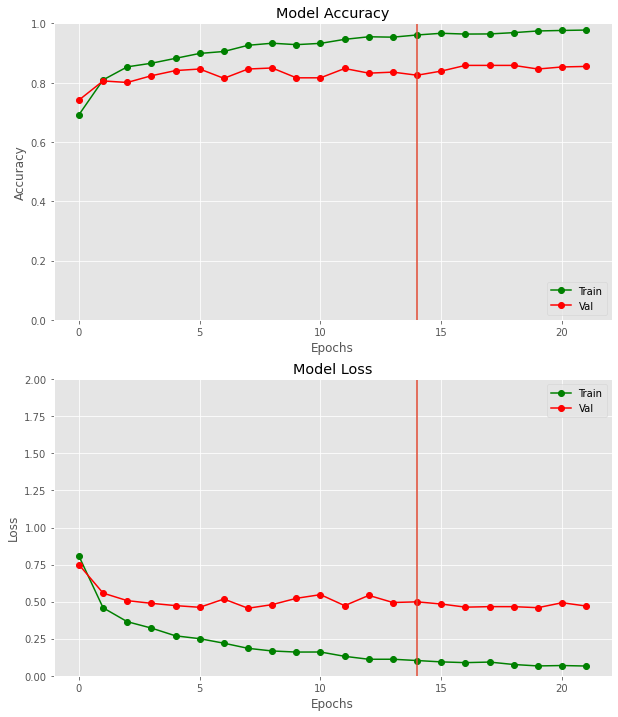

In [29]:
# Plot the training curves
train_acc += tuned_history.history['accuracy']
val_acc += tuned_history.history['val_accuracy']

train_loss += tuned_history.history['loss']
val_loss += tuned_history.history['val_loss']

plt.style.use('ggplot')
plt.figure(figsize=(10,12))

plt.subplot(2, 1, 1)
plt.plot(train_acc, 'go-', label='Training Accuracy')
plt.plot(val_acc, 'ro-', label='Validation Accuracy')
plt.ylim([0, 1.0])
plt.plot([num_train_epochs-1, num_train_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(train_loss, 'go-', label='Training Loss')
plt.plot(val_loss, 'ro-', label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([num_train_epochs-1, num_train_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

Model evaluation

In [30]:
# Get the labels
predictions = np.array([])
true_labels = np.array([])

for batch in range(len(test_data)):
    x, y = test_data[batch]
    predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=-1)])
    true_labels = np.concatenate([true_labels, y])

# Look at the first 10 predictions and labels
print('predictions = ', predictions[:10])
print('True labels = ', true_labels[:10])

predictions =  [2. 1. 0. 1. 1. 1. 3. 3. 1. 1.]
True labels =  [0. 0. 0. 3. 0. 1. 3. 3. 0. 1.]


In [31]:
# Confusion matrix
cm = tf.math.confusion_matrix(true_labels, predictions)
print('Confusion matrix:', cm)

Confusion matrix: tf.Tensor(
[[ 21  48  30   1]
 [  0 113   1   1]
 [  0   1 103   1]
 [  0  10  10  54]], shape=(4, 4), dtype=int32)


In [32]:
# Classification Report
print('Classification Report:\n')
print(classification_report(true_labels, predictions, target_names=test_data.class_indices.keys()))

Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.21      0.35       100
meningioma_tumor       0.66      0.98      0.79       115
        no_tumor       0.72      0.98      0.83       105
 pituitary_tumor       0.95      0.73      0.82        74

        accuracy                           0.74       394
       macro avg       0.83      0.73      0.70       394
    weighted avg       0.81      0.74      0.69       394



## **5. Unfreeze more layers of the base EfficientNetB3 model**

In [33]:
fine_tune_at_layer_idx = getLayerIndexByName(base_model, 'block6a_expand_conv')
print("Block 6 of EfficientNetB3 model starts at layer", fine_tune_at_layer_idx)

Block 6 of EfficientNetB3 model starts at layer 264


In [34]:
# Set all layers in block 6 to trainable while keeping the BatchNormalization layers frozen
base_model.trainable = True

# Keep the bottom layers frozen
for layer in base_model.layers[:fine_tune_at_layer_idx]:
    layer.trainable = False

# Keep the BatchNormalization layers at the top frozen
for layer in base_model.layers[fine_tune_at_layer_idx:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

In [35]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 10, 10, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1536)              6144      
_________________________________________________________________
dense (Dense)                (None, 1024)              1573888   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
predict (Dense)              (None, 4)                 4100  

In [36]:
model.compile(optimizer=Adam(learning_rate=base_learning_rate/10),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [37]:
total_epochs = 80
tuned_history = model.fit(train_data, 
                          epochs=total_epochs,
                          initial_epoch=tuned_history.epoch[-1] ,
                          validation_data=val_data, 
                          class_weight = class_weights_dict,
                          verbose=1,
                          callbacks=earlystop)

Epoch 21/80
144/144 [==============================] - 67s 413ms/step - loss: 0.0632 - accuracy: 0.9747 - val_loss: 0.4796 - val_accuracy: 0.8621
Epoch 22/80
144/144 [==============================] - 57s 398ms/step - loss: 0.0615 - accuracy: 0.9747 - val_loss: 0.4548 - val_accuracy: 0.8569
Epoch 23/80
144/144 [==============================] - 57s 399ms/step - loss: 0.0495 - accuracy: 0.9822 - val_loss: 0.4607 - val_accuracy: 0.8551
Epoch 24/80
144/144 [==============================] - 57s 398ms/step - loss: 0.0412 - accuracy: 0.9865 - val_loss: 0.4609 - val_accuracy: 0.8726
Epoch 25/80
144/144 [==============================] - 57s 398ms/step - loss: 0.0440 - accuracy: 0.9865 - val_loss: 0.4322 - val_accuracy: 0.8709
Epoch 26/80
144/144 [==============================] - 58s 400ms/step - loss: 0.0407 - accuracy: 0.9830 - val_loss: 0.5381 - val_accuracy: 0.8377
Epoch 27/80
144/144 [==============================] - 57s 398ms/step - loss: 0.0351 - accuracy: 0.9904 - val_loss: 0.4731 -

In [38]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=2)
print(f'Test accuracy is {test_accuracy*100:.2f}%')

13/13 - 2s - loss: 1.6947 - accuracy: 0.7538
Test accuracy is 75.38%


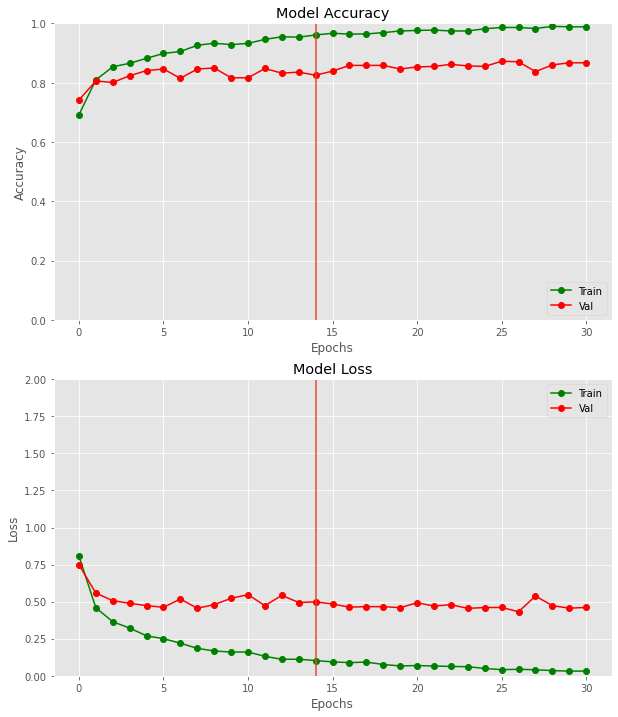

In [39]:
# Plot the training curves
train_acc += tuned_history.history['accuracy']
val_acc += tuned_history.history['val_accuracy']

train_loss += tuned_history.history['loss']
val_loss += tuned_history.history['val_loss']

plt.style.use('ggplot')
plt.figure(figsize=(10,12))

plt.subplot(2, 1, 1)
plt.plot(train_acc, 'go-', label='Training Accuracy')
plt.plot(val_acc, 'ro-', label='Validation Accuracy')
plt.ylim([0, 1.0])
plt.plot([num_train_epochs-1, num_train_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(train_loss, 'go-', label='Training Loss')
plt.plot(val_loss, 'ro-', label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([num_train_epochs-1, num_train_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [40]:
# Get the labels
predictions = np.array([])
true_labels = np.array([])

for batch in range(len(test_data)):
    x, y = test_data[batch]
    predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=-1)])
    true_labels = np.concatenate([true_labels, y])

# Look at the first 10 predictions and labels
print('predictions = ', predictions[:10])
print('True labels = ', true_labels[:10])

predictions =  [2. 2. 2. 2. 1. 1. 1. 1. 1. 0.]
True labels =  [2. 2. 2. 2. 1. 1. 0. 1. 1. 0.]


In [41]:
# Confusion matrix
cm = tf.math.confusion_matrix(true_labels, predictions)
print('Confusion matrix:', cm)

Confusion matrix: tf.Tensor(
[[ 25  45  28   2]
 [  0 113   2   0]
 [  0   1 103   1]
 [  0   5  13  56]], shape=(4, 4), dtype=int32)


In [42]:
# Classification Report
print('Classification Report:\n')
print(classification_report(true_labels, predictions, target_names=test_data.class_indices.keys()))

Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.25      0.40       100
meningioma_tumor       0.69      0.98      0.81       115
        no_tumor       0.71      0.98      0.82       105
 pituitary_tumor       0.95      0.76      0.84        74

        accuracy                           0.75       394
       macro avg       0.84      0.74      0.72       394
    weighted avg       0.82      0.75      0.71       394



## **6. Save model performance**

In [43]:
report = classification_report(true_labels, predictions, target_names=test_data.class_indices.keys(), output_dict=True)
performance = {'Model': [],
               'Train accuracy': [],
               'Train loss': [],
               'Test accuracy': [],
               'Test loss': [],
               'Glioma Precision': [],
               'Glioma Recall': [],
               'Meningioma Precision': [],
               'Meningioma Recall': [],
               'No Tumor Precision': [],
               'No Tumor Recall': [],
               'Pituitary Precision': [],
               'Pituitary Recall': []
               }

performance['Model'].append('EfficientNetB3 model')
performance['Train accuracy'].append(train_acc[-1])
performance['Train loss'].append(train_loss[-1])
performance['Test accuracy'].append(test_accuracy)
performance['Test loss'].append(test_loss)
performance['Glioma Precision'].append(report['glioma_tumor']['precision'])
performance['Glioma Recall'].append(report['glioma_tumor']['recall'])
performance['Meningioma Precision'].append(report['meningioma_tumor']['precision'])
performance['Meningioma Recall'].append(report['meningioma_tumor']['recall'])
performance['No Tumor Precision'].append(report['no_tumor']['precision'])
performance['No Tumor Recall'].append(report['no_tumor']['recall'])
performance['Pituitary Precision'].append(report['pituitary_tumor']['precision'])
performance['Pituitary Recall'].append(report['pituitary_tumor']['recall'])

df_performance = pd.DataFrame(performance)
df_performance.to_csv('EfficientNetB3_performance.csv', index=False)